In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pair_confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

random_state = 42

In [3]:
#load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df0 = pd.read_csv(url)

In [4]:
df0.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df0.describe(include= "all")

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [6]:
print("The dataset has {} number of rows and {} number of columns respectively".format(df0.shape[0],df0.shape[1]))

The dataset has 440 number of rows and 8 number of columns respectively


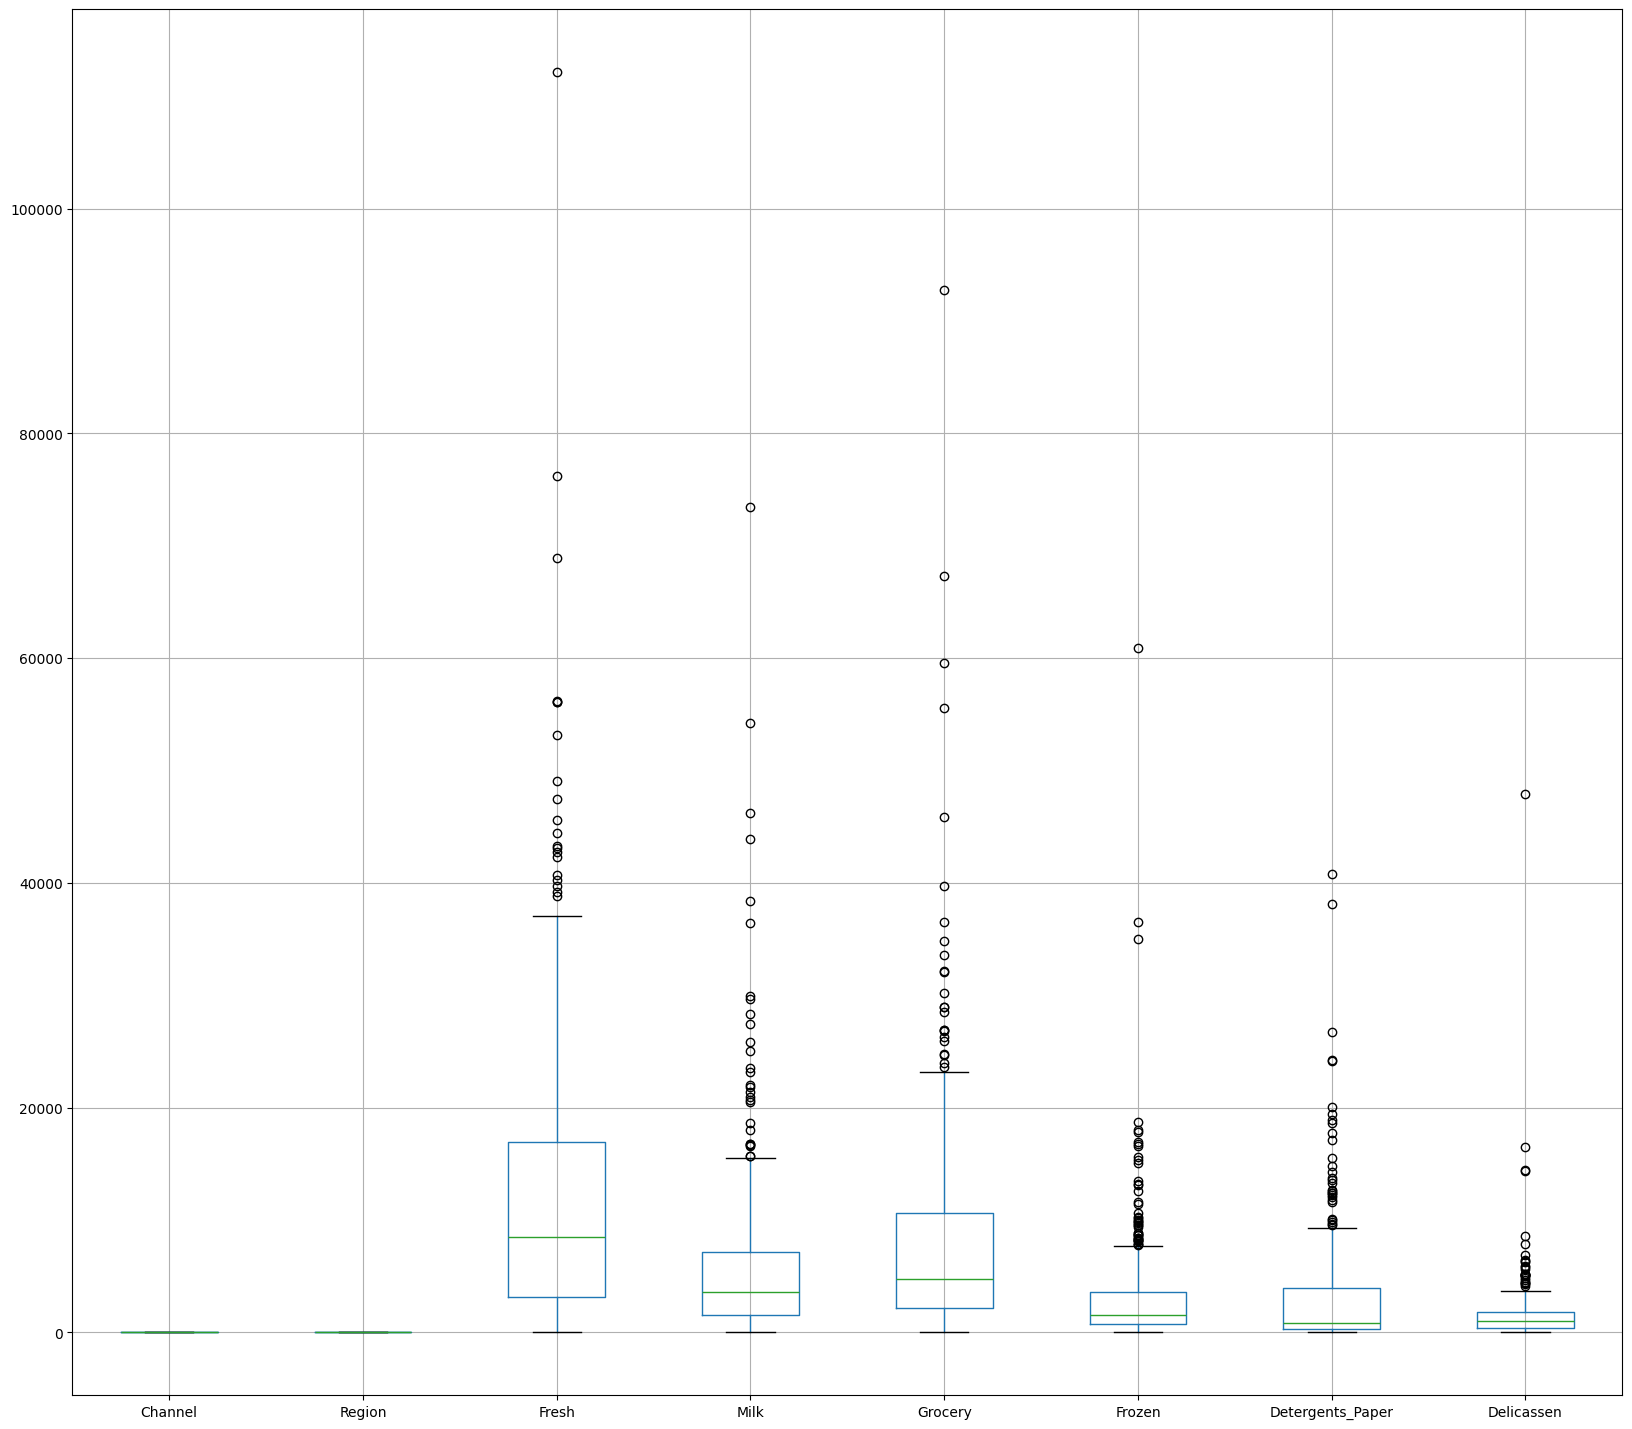

In [7]:
#EDA
df0.boxplot(figsize=(20,18))
plt.show()

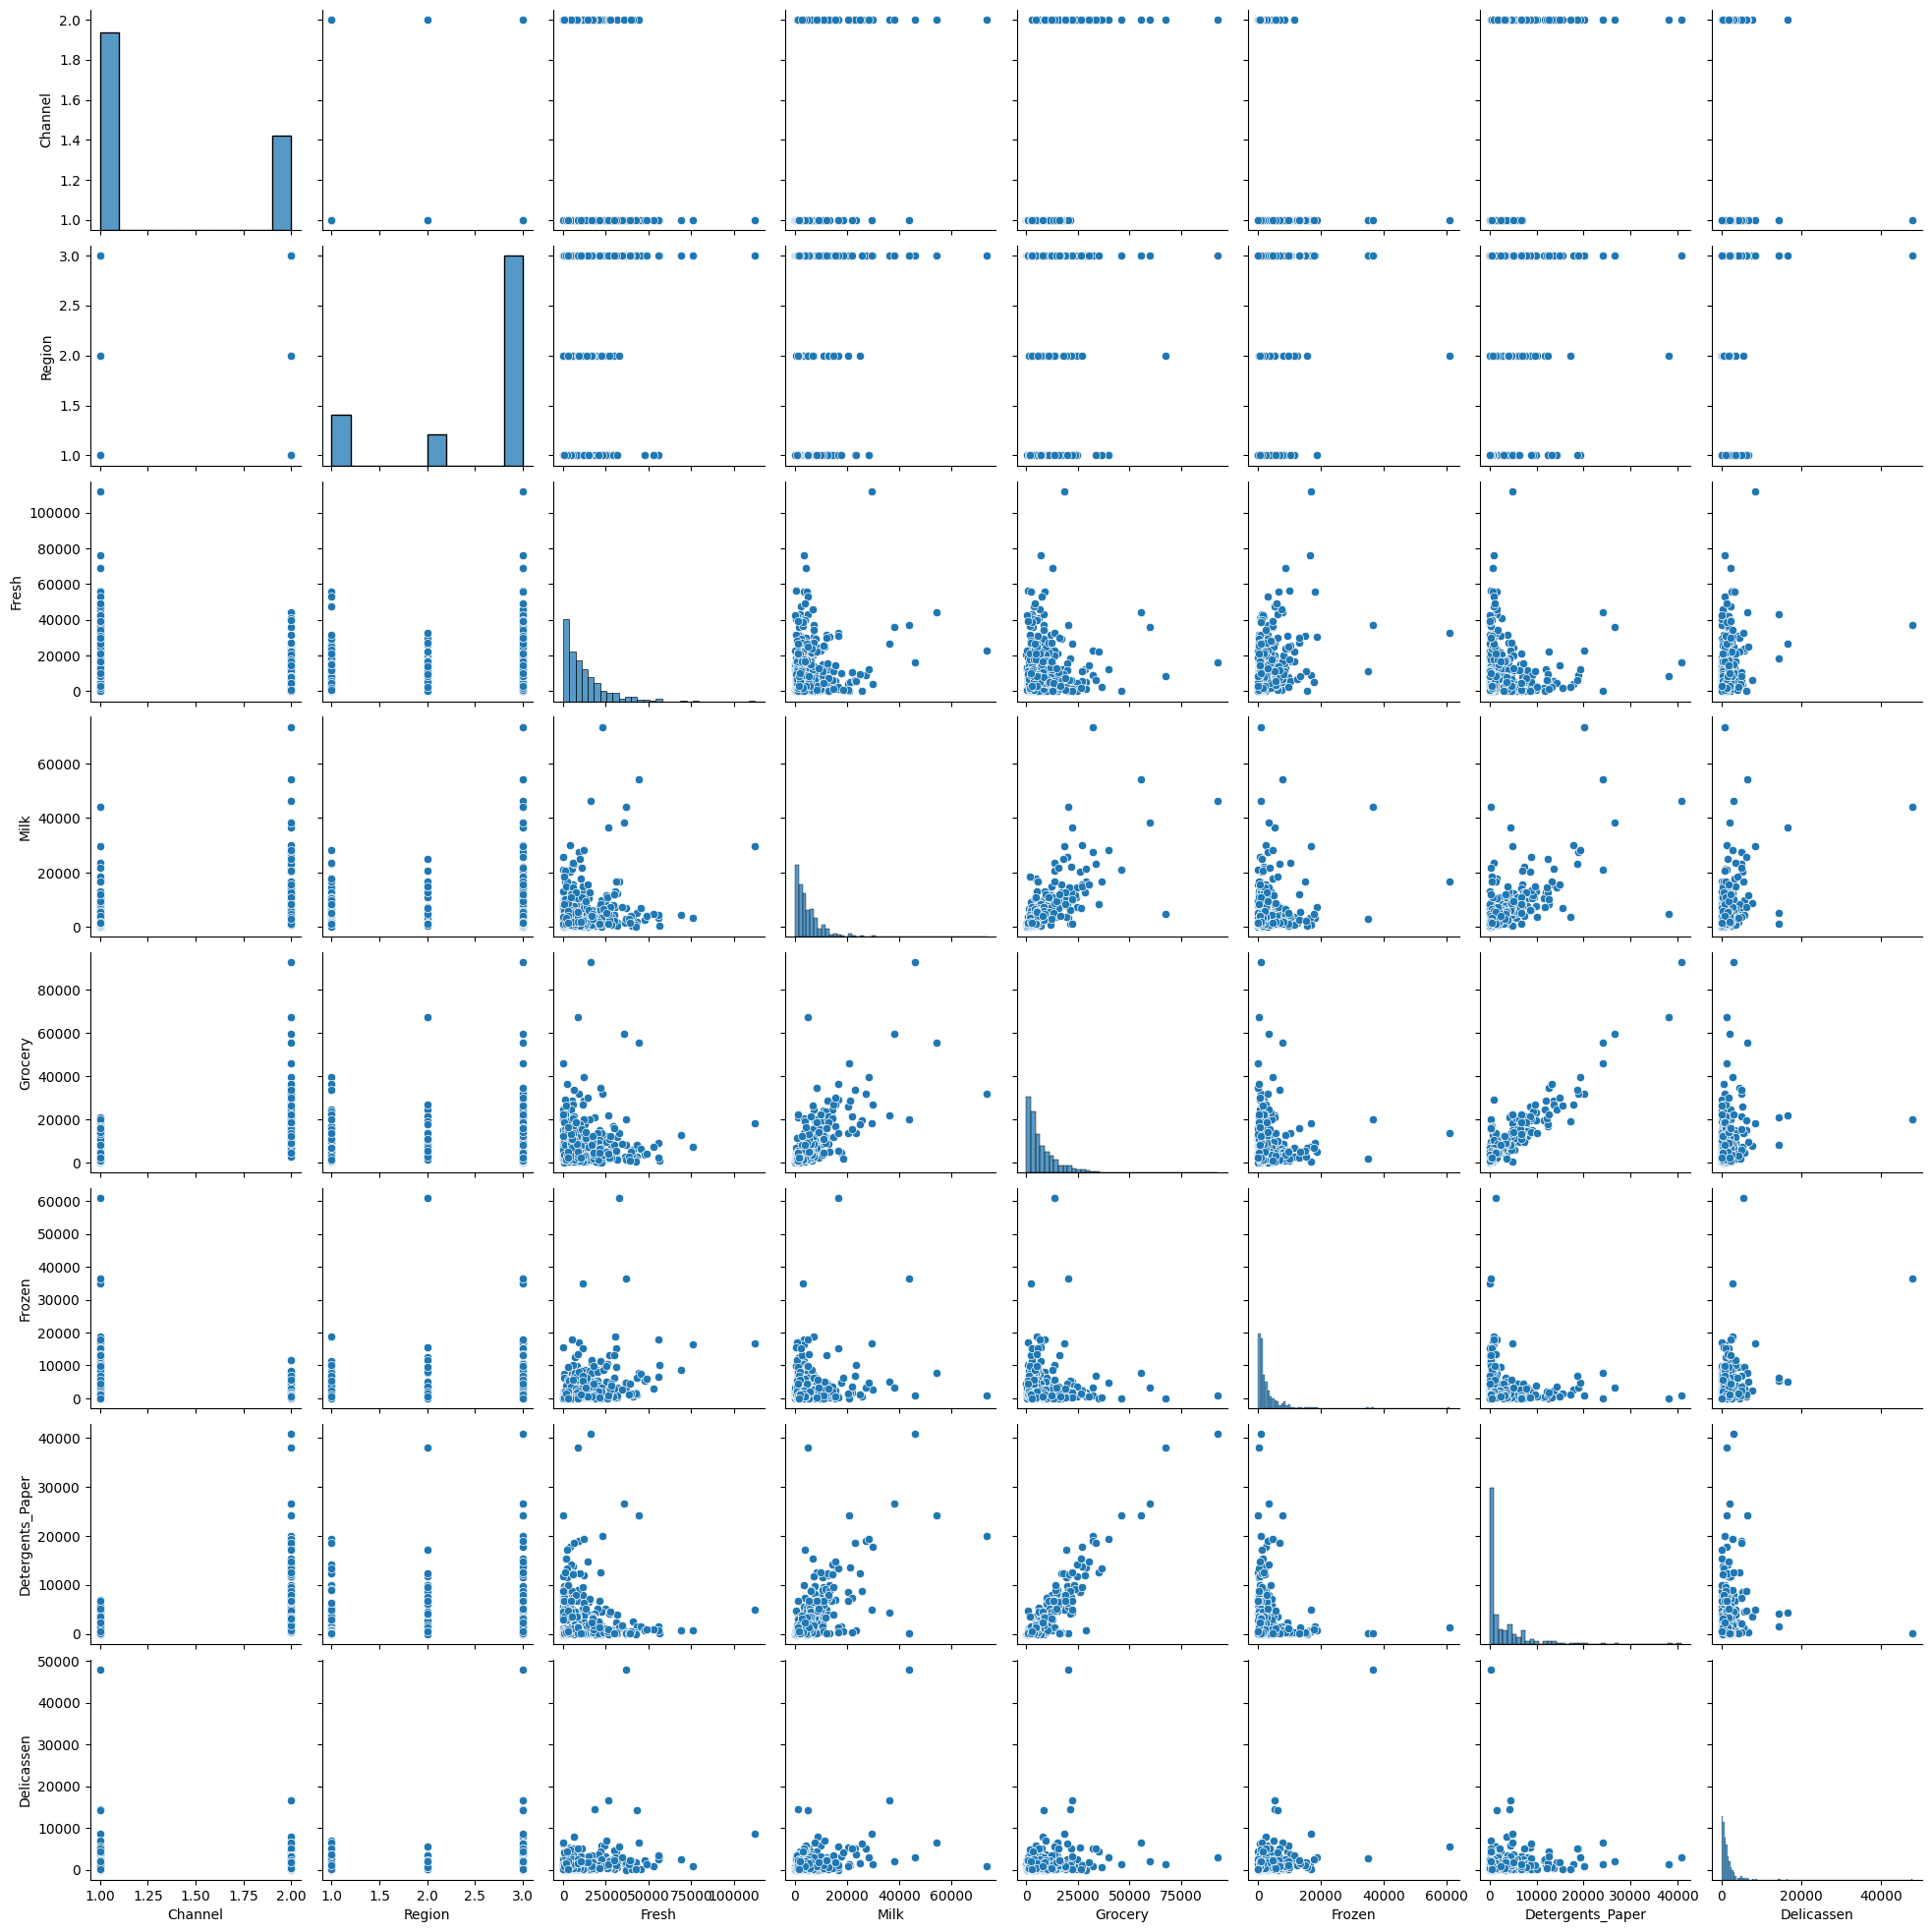

In [8]:
sns.pairplot(df0)
plt.show()

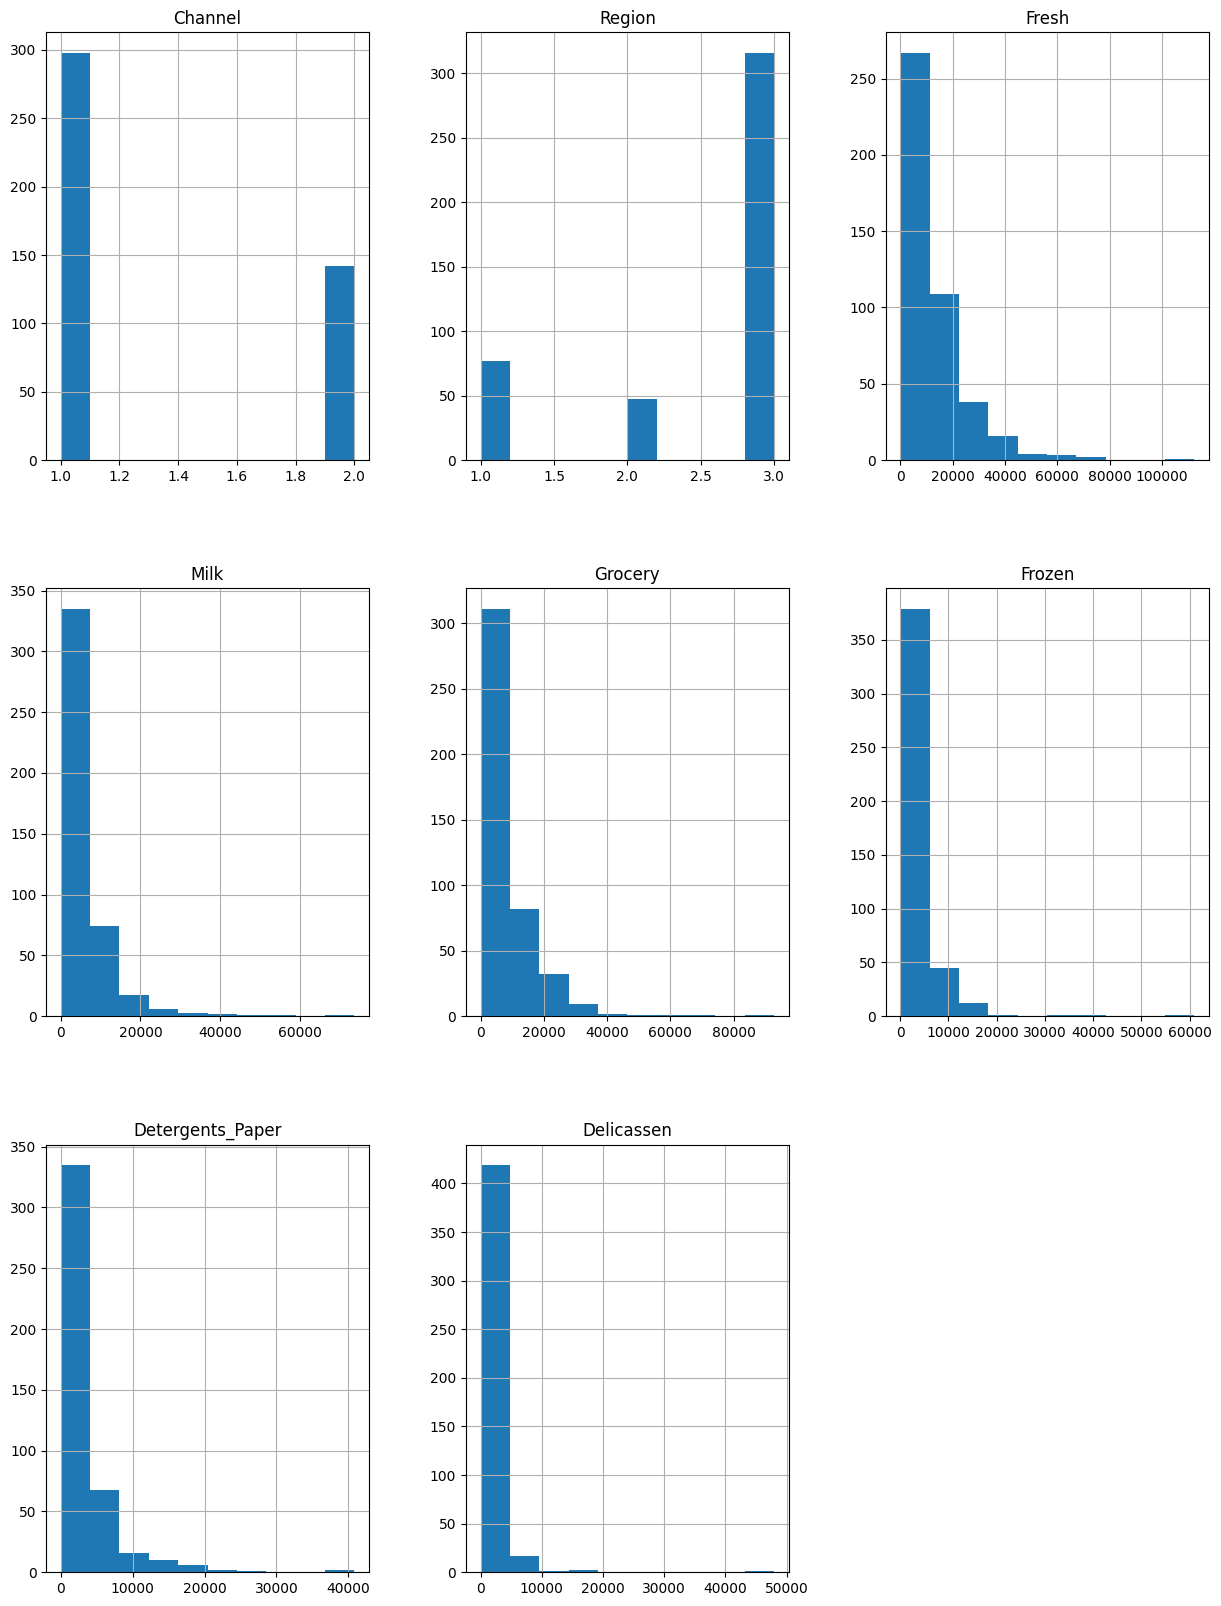

In [11]:
df0.hist(figsize=(15,20))
plt.show()

In [16]:
#powertransformer reduces skewness
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
x_pt = pd.DataFrame(pt.fit_transform(df0.iloc[:,2:]),
columns = df0.columns[2:]
)
#we need to re-attach the columns as well again
x_transf = pd.concat([df0.iloc[:,:2], x_pt] , axis = 1)

In [19]:
#Min–Max Scaling (distance fairness)
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

X= pd.DataFrame(mms.fit_transform(x_transf),
columns = x_transf.columns
)
#All features scaled to [0,1]
#Required for meaningful distance computation

In [20]:
#Agglomerative hyperparameters: n_clusters and linkage
#defien hyperparameter grid
k_range = list(range(2,11))
parameters = [{'n_clusters' : k_range,
               'linkage' : ['ward', 'complete', 'average', 'single']

               }]
pg = list(ParameterGrid(parameters))

In [21]:
X.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.501828,0.667606,0.625238,0.208640,0.649941,0.412016
1,1.0,1.0,0.414266,0.670028,0.655690,0.458800,0.674852,0.445663
2,1.0,1.0,0.400077,0.653586,0.627297,0.499856,0.682752,0.654292
3,0.0,1.0,0.509368,0.369264,0.553550,0.636716,0.461095,0.446485
4,1.0,1.0,0.604755,0.580657,0.618985,0.566470,0.601884,0.590255


In [23]:
#Grid search using silhouette score

result_ac = []
for i in range(len(pg)):
  ac = AgglomerativeClustering(**pg[i])
  y_ac = ac.fit_predict(X)
  result_ac.append([pg[i]['linkage'] , pg[i]['n_clusters'] , silhouette_score(X,y_ac)])


In [24]:
#Results table & sorting
df_result_ac = pd.DataFrame(result_ac , columns = ['linkage' , 'n_clusters', 'silhouette_score'])
df_result_ac.sort_values(by = 'silhouette_score' , ascending = False)

,linkage,n_clusters,silhouette_score
0,ward,2,0.499350
27,single,2,0.499350
18,average,2,0.499350
9,complete,2,0.499350
1,ward,3,0.498333
2,ward,4,0.493085
20,average,4,0.479507
11,complete,4,0.479507
21,average,5,0.475050
22,average,6,0.443867


Why not blindly choose k = 2?

Because:

Differences in silhouette are very small

k = 2 often oversimplifies the data

You want comparability with K-Means, which gave k = 4

This is correct scientific reasoning, not just coding.

Choosing k = 4 with ward is fully justified.

In [25]:
print(df_result_ac.iloc[2])

linkage                 ward
n_clusters                 4
silhouette_score    0.493085
Name: 2, dtype: object


In [26]:
#now we are doing with the best cluster we have fpund based on sil score and linkage
ac = AgglomerativeClustering(n_clusters = 4 , linkage = 'ward')
y_ac = ac.fit_predict(X)
#now this is the final clustering result


Cluster size analysis (VERY IMPORTANT)
What this checks

All clusters are populated

No extremely small or empty clusters

Clustering is meaningful

 Balanced clusters → good solution

In [34]:
clust_sizes_ac = np.unique(y_ac, return_counts=True)
print(clust_sizes_ac)



(array([0, 1, 2, 3]), array([212,  37,  86, 105]))


In [33]:
from sklearn.metrics import silhouette_score

# Final silhouette score
final_sil_score = silhouette_score(X, y_ac)

# Best parameters from your grid search
best_params = df_result_ac.iloc[2]  # contains linkage, n_clusters, silhouette_score

print("=== Final Agglomerative Clustering Results ===")
print(f"Number of clusters: {best_params.n_clusters}")
print(f"Linkage method: {best_params.linkage}")
print(f"Silhouette score from fit: {final_sil_score:.4f}")


=== Final Agglomerative Clustering Results ===
Number of clusters: 4
Linkage method: ward
Silhouette score from fit: 0.4931


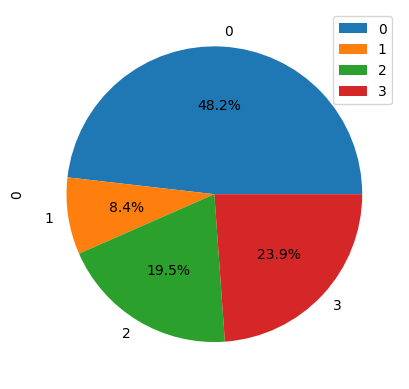

In [35]:
#make pieplot
pd.DataFrame(clust_sizes_ac[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

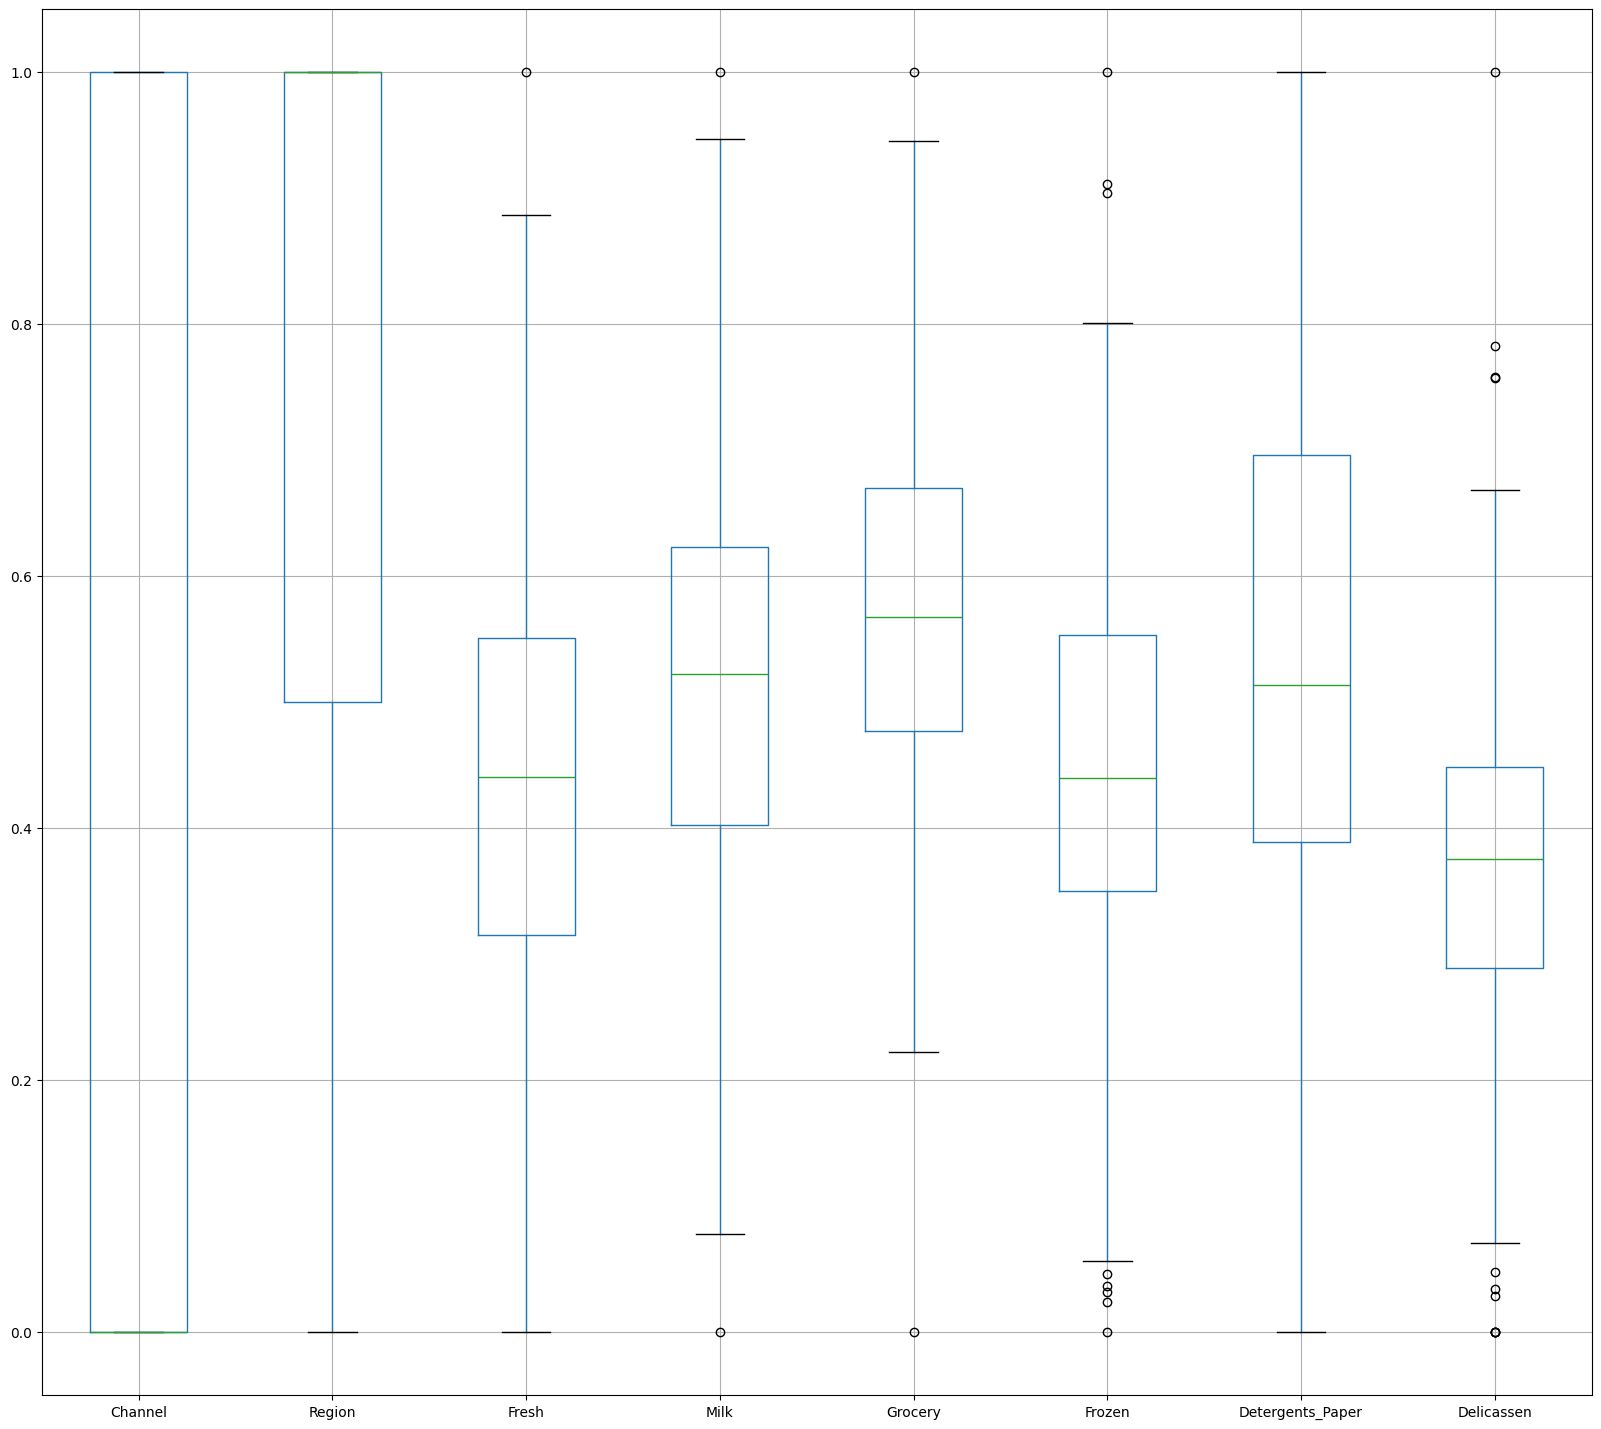

In [40]:
X.boxplot(figsize=(20,18))
plt.show()

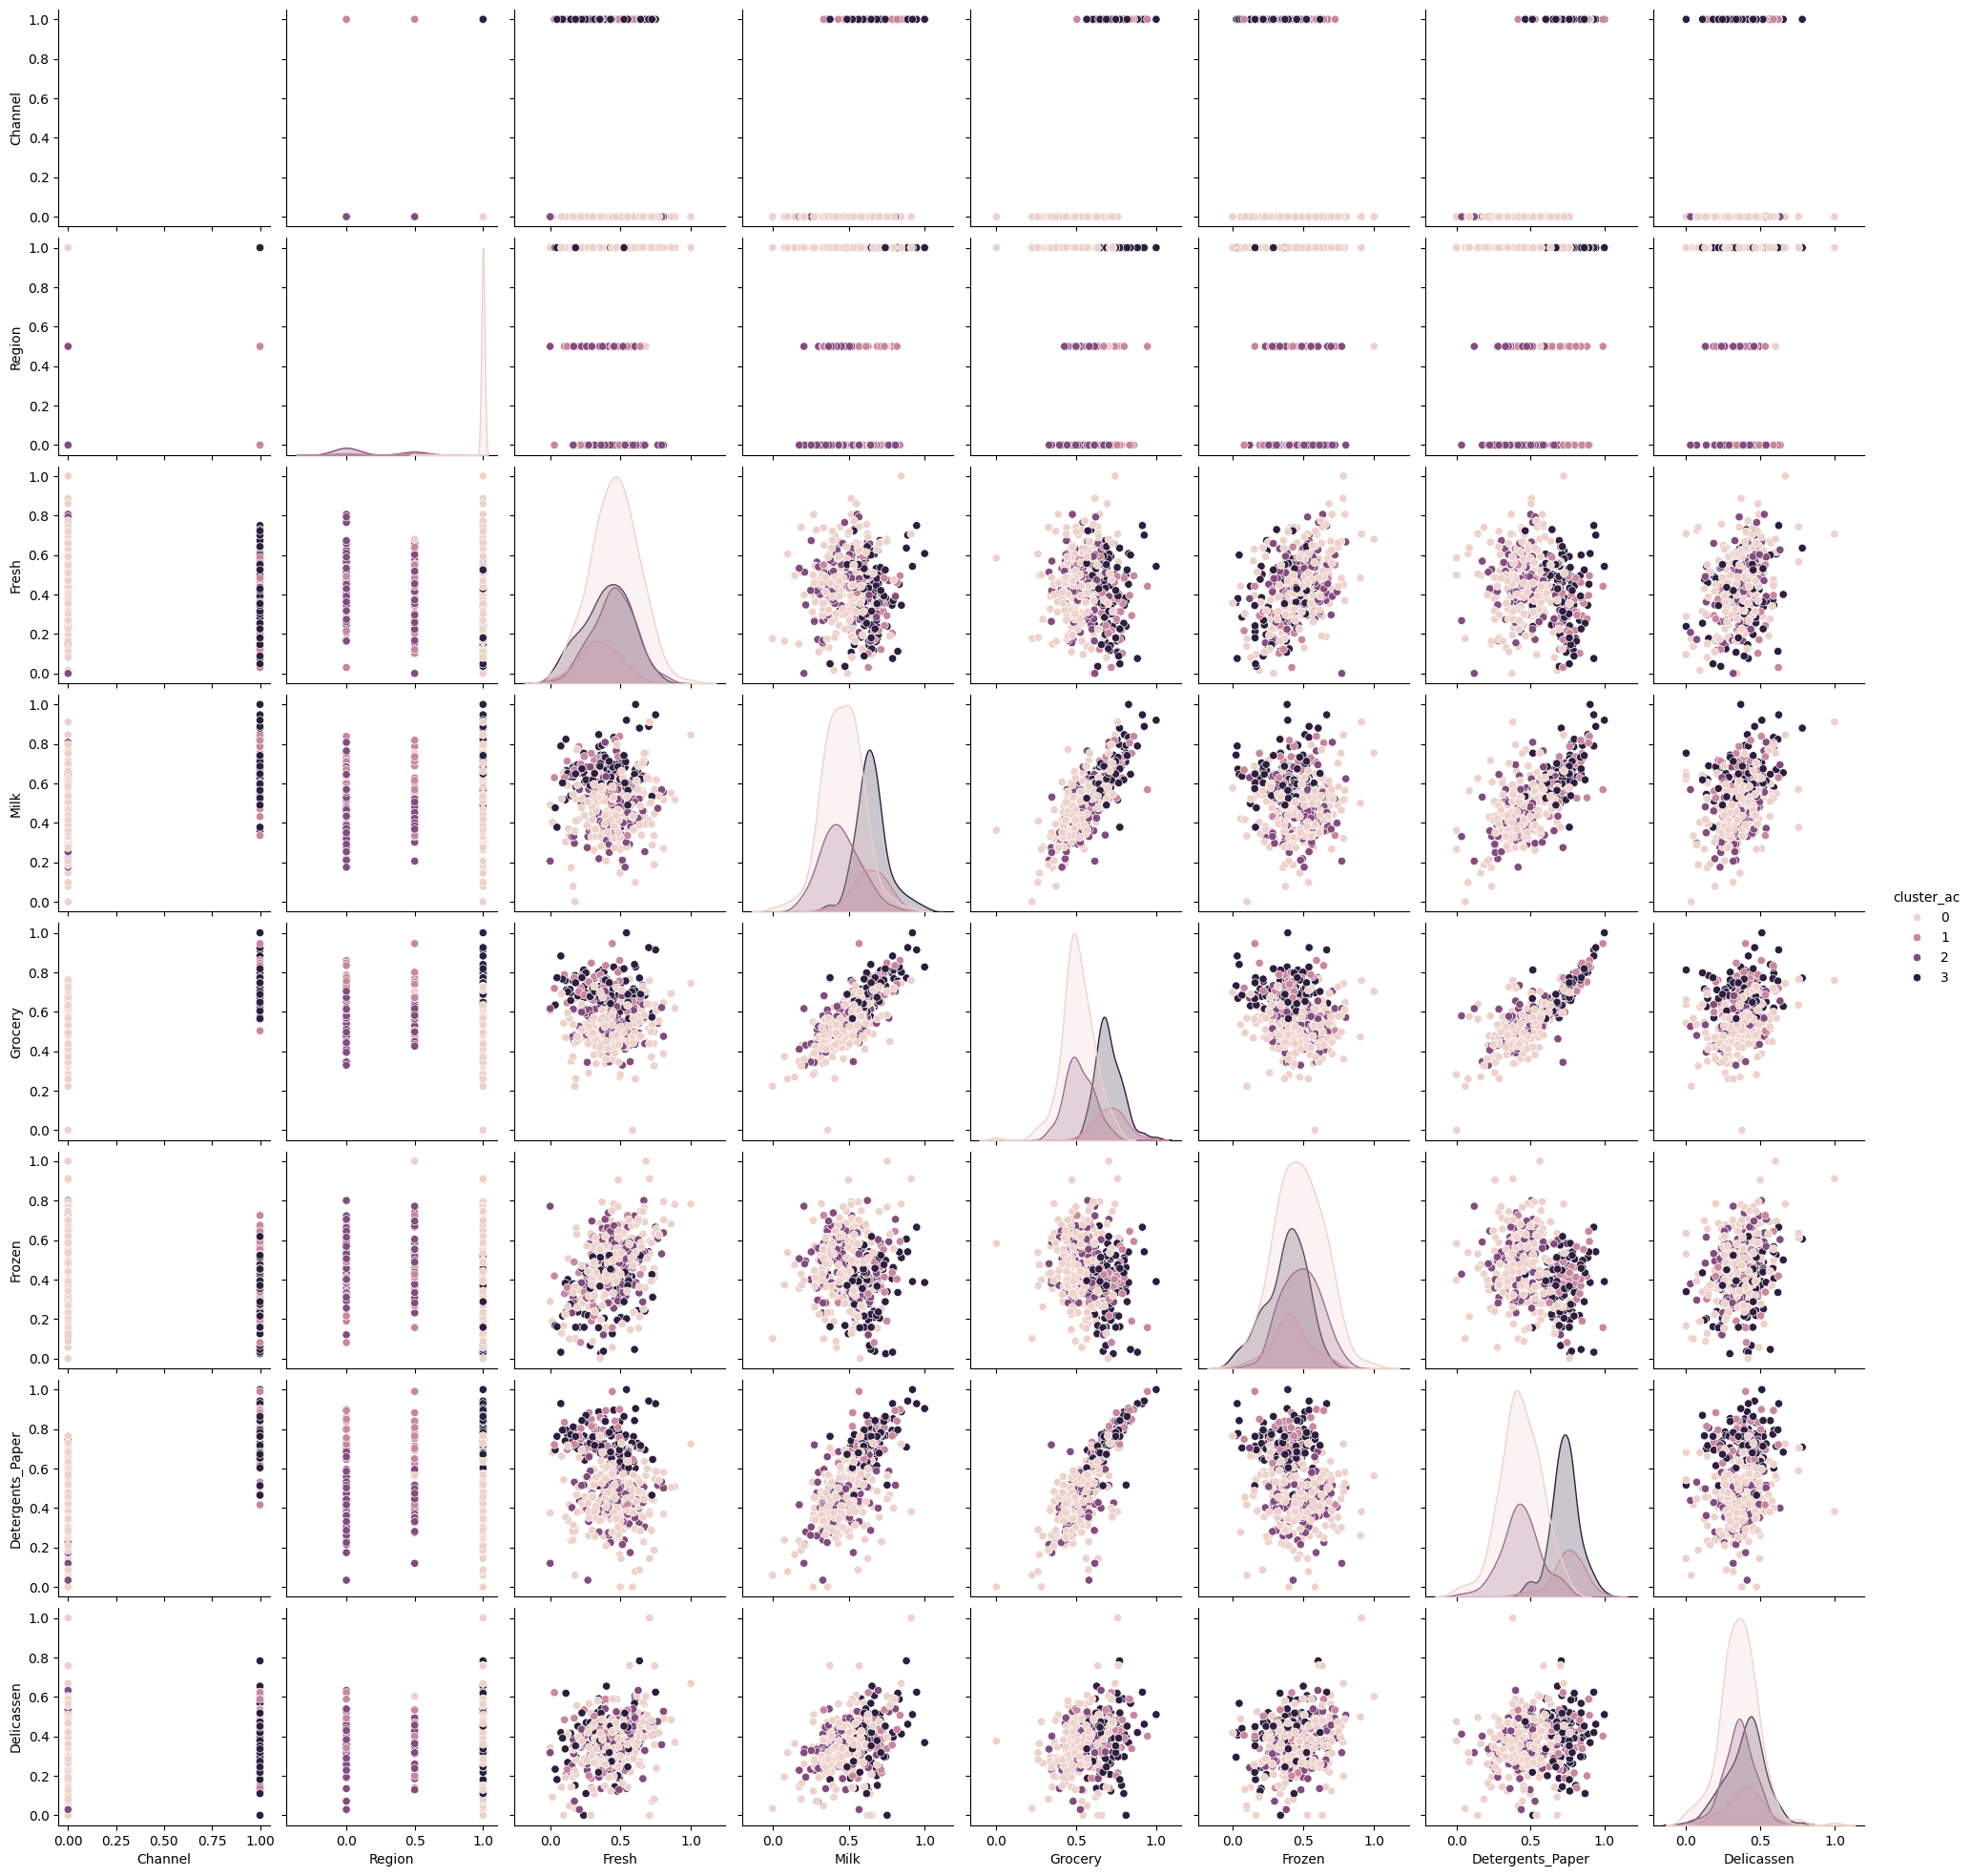

In [47]:
X_plot = X.copy()
X_plot['cluster_ac'] = y_ac
sns.pairplot(X_plot, hue='cluster_ac')
plt.show()




### **Comment on the Agglomerative Clustering Pairplot:**

1. **Cluster separation:**

   * The clusters are moderately well separated along certain features like **Fresh, Milk, Grocery**, and **Detergents_Paper**.
   * Clusters 0 and 1 are visually distinct in some scatterplots, while clusters 2 and 3 overlap more in features like **Frozen** and **Delicassen**.

2. **Feature contribution:**

   * Features **Fresh, Milk, Grocery** seem to contribute most to the clustering, as the points of different clusters occupy distinct regions.
   * Categorical features like **Channel** and **Region** show vertical or horizontal stripes, indicating that they have less influence on clustering.

3. **Cluster sizes and distribution:**

   * From the density plots on the diagonal, we see that some clusters contain more samples than others (e.g., cluster 3 has slightly higher density in **Delicassen**).
   * This matches the earlier pie chart showing cluster sizes.

4. **Overlap:**

   * Some clusters overlap in certain feature combinations (e.g., **Frozen vs Grocery**), suggesting that not all features perfectly separate the clusters.
   * This is expected, as real-world data often has clusters that are not completely separable.

**Overall:**
The Agglomerative clustering with 4 clusters and **ward linkage** captures the main structure of the data, with clear separation along major features, while some overlap exists in less discriminative features.

